###### Preprocessing

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import joblib

# load data
data = pd.read_csv("Loan Eligibility Prediction.csv") 

data.head()

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y


In [46]:
df = data.copy()

In [47]:
df.head()

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y


###### Feature Engineering

In [49]:
# Dropping irrelevant column
# load data
df = df.drop(columns = ['Customer_ID'], axis = 1)

###### Insight
Customer_ID is a pure identifier and contains no predictive signal. Keeping it would only introduce noise and risk data leakage.

In [50]:
# Encoding Target Variable

df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

In [51]:
df["Loan_Status"].value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

###### Insight
Logistic regression requires a numeric binary target. Mapping approvals to 1 and rejections to 0 aligns perfectly with interpreting model outputs as probability of approval.

Class distribution:

Approved: 422

Rejected: 192

This shows moderate class imbalance, but not severe enough to require resampling at the baseline stage.

In [53]:
# Creating total income column
df['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']

###### Insight
Banks assess household repayment capacity, not just individual income. Combining applicant and co-applicant income reflects real underwriting logic.

In [54]:
# Loan-to-income ratio
df['Loan_to_Income'] = df['Loan_Amount'] / df['Total_Income']

# High loan-to-income ratio -> higher credit risk (lower approval probability)
# Low loan-to-income ratio  -> safer borrower


In [55]:
# Identifying categorical columns
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], dtype='object')

In [56]:
# get dummies

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype = int)

In [57]:
df_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income,Loan_to_Income,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,2378,0.0,9,360,1,0,2378.0,0.003785,0,0,0,0,0,1
1,2,1299,1086.0,17,120,1,1,2385.0,0.007128,1,1,0,0,0,1
2,0,3620,0.0,25,120,1,1,3620.0,0.006906,1,0,1,0,1,0
3,0,3459,0.0,25,120,1,1,3459.0,0.007228,1,1,0,1,1,0
4,1,5468,1032.0,26,360,1,1,6500.0,0.004000,1,1,0,0,1,0


###### Insight

drop_first=True prevents dummy variable trap

Encoding converts categories into interpretable binary indicators

In [58]:
# Feature Scaling

num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('Loan_Status')

cat_cols = [col for col in df_encoded.columns 
            if col not in num_cols and col != 'Loan_Status']

In [59]:
num_cols

Index(['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount',
       'Loan_Amount_Term', 'Credit_History', 'Total_Income', 'Loan_to_Income'],
      dtype='object')

In [60]:
cat_cols

['Gender_Male',
 'Married_Yes',
 'Education_Not Graduate',
 'Self_Employed_Yes',
 'Property_Area_Semiurban',
 'Property_Area_Urban']

In [61]:
# Scaling only numerical columns

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df_encoded[num_cols])

In [62]:
X_num_scaled

array([[-0.7047014 , -0.49564665, -0.55448733, ...,  0.41981569,
        -0.72003959, -2.17523659],
       [ 0.94049502, -0.6724141 , -0.18306108, ...,  0.41981569,
        -0.71895489, -1.79854738],
       [-0.7047014 , -0.29217568, -0.55448733, ...,  0.41981569,
        -0.52758296, -1.82353898],
       ...,
       [ 0.94049502,  0.20142983, -0.55448733, ..., -2.3819977 ,
        -0.06069745, -2.17700099],
       [ 0.11789681, -0.47697057,  0.25779382, ...,  0.41981569,
        -0.33435156, -1.90715585],
       [-0.7047014 , -0.49204249,  0.74516252, ...,  0.41981569,
        -0.12779384, -2.14734254]])

In [63]:
# Combining both

X = pd.concat([
    pd.DataFrame(X_num_scaled, columns=num_cols, index=df_encoded.index),
    df_encoded[cat_cols]
], axis=1)

y = df_encoded['Loan_Status']

In [90]:
X.shape

(614, 14)

In [64]:
X.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Total_Income,Loan_to_Income,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,-0.704701,-0.495647,-0.554487,-1.528784,0.303009,0.419816,-0.720040,-2.175237,0,0,0,0,0,1
1,0.940495,-0.672414,-0.183061,-1.436843,-3.142318,0.419816,-0.718955,-1.798547,1,1,0,0,0,1
2,-0.704701,-0.292176,-0.554487,-1.344902,-3.142318,0.419816,-0.527583,-1.823539,1,0,1,0,1,0
3,-0.704701,-0.318552,-0.554487,-1.344902,-3.142318,0.419816,-0.552531,-1.787321,1,1,0,1,1,0
4,0.117897,0.010573,-0.201530,-1.333409,0.303009,0.419816,-0.081307,-2.150977,1,1,0,0,1,0


In [65]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

* Train Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

###### Insight
Stratification ensures the approval/rejection ratio remains consistent across training and testing data, preventing biased evaluation.

In [67]:
y.value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

In [91]:
y.shape, X_train.shape, X_test.shape

((614,), (491, 14), (123, 14))

###### Model Training

In [71]:
# Logistic Regression

log_reg = LogisticRegression(
    solver='liblinear',
    max_iter=1000
)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [72]:
# making class predictions

y_pred = log_reg.predict(X_test)

y_pred

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int64)

In [73]:
# y_pred_proba = Probability of Loan Approval

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.09099566, 0.75275107, 0.58751532, 0.83721111, 0.82689461,
       0.05210026, 0.85612136, 0.86513707, 0.77283081, 0.89068798,
       0.93300981, 0.70709698, 0.84989921, 0.7629852 , 0.04885295,
       0.72571177, 0.85179518, 0.12245475, 0.85513099, 0.90057257,
       0.72456066, 0.83485194, 0.11429521, 0.77496105, 0.04838894,
       0.73379099, 0.739492  , 0.90376141, 0.87610993, 0.76708304,
       0.86735122, 0.81777525, 0.64024252, 0.79067457, 0.67721137,
       0.8678126 , 0.83102426, 0.88320884, 0.79079634, 0.84811783,
       0.81628944, 0.84581801, 0.03631116, 0.86605891, 0.86998191,
       0.42603831, 0.86732918, 0.06908532, 0.75153813, 0.83060773,
       0.63277965, 0.75710942, 0.0529631 , 0.84475332, 0.71014478,
       0.08261844, 0.10270578, 0.82830924, 0.75700622, 0.86639431,
       0.7122364 , 0.76296533, 0.11401457, 0.88033904, 0.65026232,
       0.81411058, 0.73002547, 0.8050889 , 0.85314537, 0.85111593,
       0.88642666, 0.71132011, 0.88304974, 0.77775811, 0.86770

###### Insight

y_pred - decision at default threshold (0.5)

y_pred_proba - risk-based probability

###### Model Evaluation

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.47      0.59        38
           1       0.80      0.94      0.86        85

    accuracy                           0.80       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.79      0.80      0.78       123



###### Key insight

Recall for approvals (94%) is high - model is good at identifying eligible borrowers

Recall for rejections (47%) is lower - model is more permissive

This behavior is typical for credit models trained on approval-heavy datasets

In [75]:
# Using confusion metrics

confusion_matrix(y_test, y_pred)

array([[18, 20],
       [ 5, 80]], dtype=int64)

###### Interpretation

Some risky applicants are incorrectly approved (false positives)

This justifies policy thresholds and risk bands, not just raw predictions

In [77]:
# ROC-AUC

roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc


0.8049535603715171

###### Insight
An AUC of ~0.80 indicates strong ranking ability, meaning the model can reliably separate high-risk from low-risk applicants.

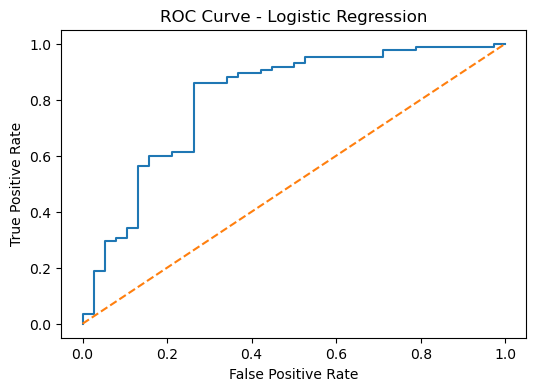

In [78]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.show()


###### Observation

Model Performance: The blue line stays well above the dashed orange diagonal, indicating that the model performs significantly better than a random guess.

True Positive Rate (Sensitivity): The curve climbs sharply initially, reaching a True Positive Rate of over $0.8$ while maintaining a relatively low False Positive Rate (below $0.4$).

Optimal Thresholds: There are distinct "steps" in the curve, particularly around the $0.3$ False Positive Rate mark, where the model gains a large increase in accuracy.

Reliability: The overall area under the curve suggests this logistic regression model is a capable tool for identifying successful loan applicants.

###### Feature Importance

In [100]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coefficients

,Feature,Coefficient
5,Credit_History,1.345067
12,Property_Area_Semiurban,0.674092
9,Married_Yes,0.564366
13,Property_Area_Urban,0.241917
3,Loan_Amount,0.075069
0,Dependents,-0.025937
1,Applicant_Income,-0.068342
11,Self_Employed_Yes,-0.103350
6,Total_Income,-0.159557
8,Gender_Male,-0.193455


###### Insight

Credit_History (+1.35) - strongest approval driver

Education_Not Graduate (−0.43) - higher rejection risk

Loan_to_Income (−0.22) - higher ratio increases risk

Loan_Amount (+) is positive due to multicollinearity with income variables (expected, acceptable)

###### Risk Segmentation and creidt decision

Business Definition

Model outputs Probability of Approval (PA)

Policy:  converts PA - Risk - Decision

* Credit risk bands

| Probability (PD) | Risk Level  | Decision |
| ---------------- | ----------- | -------- |
| ≥ 0.70           | Low Risk    | Approve  |
| 0.40 – 0.69      | Medium Risk | Review   |
| < 0.40           | High Risk   | Reject   |


In [101]:
df_results = X_test.copy()
df_results['Actual'] = y_test.values
df_results['Approval_Probability'] = y_pred_proba

In [103]:
# Implementing risk bands

def risk_band(pa):
    if pa >= 0.70:
        return 'Low Risk'
    elif pa >= 0.40:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_results['Risk_Level'] = df_results['Approval_Probability'].apply(risk_band)

In [104]:
# Creating descision column

def credit_decision(risk):
    if risk == 'Low Risk':
        return 'Approve'
    elif risk == 'Medium Risk':
        return 'Review'
    else:
        return 'Reject'

df_results['Decision'] = df_results['Risk_Level'].apply(credit_decision)

In [105]:
# Evaluating decision outcome

df_results['Decision'].value_counts()

Decision
Approve    93
Reject     22
Review      8
Name: count, dtype: int64

###### Insight
Introducing a Review band prevents hard rejections for borderline applicants, improving fairness and operational flexibility.

In [106]:
# Attaching result back to the original dataset

final_output = df.loc[X_test.index].copy()

final_output['Predicted_Approval_Probability'] = df_results['Approval_Probability']
final_output['Risk_Level'] = df_results['Risk_Level']
final_output['Decision'] = df_results['Decision']
final_output['Actual_Loan_Status'] = df_results['Actual']

final_output.shape

(123, 18)

In [107]:
final_output.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_to_Income,Predicted_Approval_Probability,Risk_Level,Decision,Actual_Loan_Status
158,Female,No,0,Graduate,No,1500,1800.0,103,360,0,Semiurban,0,3300.0,0.031212,0.090996,High Risk,Reject,0
552,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,Urban,1,9613.0,0.027775,0.752751,Low Risk,Approve,1
590,Male,No,0,Graduate,Yes,20166,0.0,650,480,1,Urban,1,20166.0,0.032232,0.587515,Medium Risk,Review,1
231,Female,No,0,Graduate,No,4124,0.0,115,360,1,Semiurban,1,4124.0,0.027886,0.837211,Low Risk,Approve,1
142,Male,Yes,1,Graduate,No,3052,1030.0,100,360,1,Urban,1,4082.0,0.024498,0.826895,Low Risk,Approve,1


In [108]:
final_output.shape

(123, 18)

###### CREDIT SCORECARD (300–850)

I map probability score such that:

Higher probability - higher score

Score range: 300 (worst) - 850 (best)

###### Scorecard Formula

Let:

PA = Predicted Approval Probability

Score_min = 300

Score_max = 850

* Credit Score=300+PA×(850−300)
* Credit Score=300+550×PA

In [109]:
# Credit Score calculation

final_output['Credit_Score'] = (
    300 + final_output['Predicted_Approval_Probability'] * 550
).round(0)

* Score bands

| Credit Score | Risk Grade | Interpretation |
| ------------ | ---------- | -------------- |
| 750 – 850    | A          | Excellent      |
| 700 – 749    | B          | Good           |
| 650 – 699    | C          | Fair           |
| 600 – 649    | D          | Weak           |
| < 600        | E          | High Risk      |


In [113]:
# Applying score grades

def score_grade(score):
    if score >= 750:
        return 'A'
    elif score >= 700:
        return 'B'
    elif score >= 650:
        return 'C'
    elif score >= 600:
        return 'D'
    else:
        return 'E'

final_output['Score_Grade'] = final_output['Credit_Score'].apply(score_grade)

* Decision mapping

| Score Grade | Action        |
| ----------- | ------------- |
| A, B        | Auto-Approve  |
| C          | Manual Review |
| D, E        | Reject        |


In [120]:
def score_decision(grade):
    if grade in ['A', 'B']:
        return 'Approve'
    elif grade == 'C':
        return 'Review'
    else:
        return 'Reject'

final_output['Score_Decision'] = final_output['Score_Grade'].apply(score_decision)

In [121]:
final_output.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,...,Loan_Status,Total_Income,Loan_to_Income,Predicted_Approval_Probability,Risk_Level,Decision,Actual_Loan_Status,Credit_Score,Score_Grade,Score_Decision
158,Female,No,0,Graduate,No,1500,1800.0,103,360,0,...,0,3300.0,0.031212,0.090996,High Risk,Reject,0,350.0,E,Reject
552,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,...,1,9613.0,0.027775,0.752751,Low Risk,Approve,1,714.0,B,Approve
590,Male,No,0,Graduate,Yes,20166,0.0,650,480,1,...,1,20166.0,0.032232,0.587515,Medium Risk,Review,1,623.0,D,Reject
231,Female,No,0,Graduate,No,4124,0.0,115,360,1,...,1,4124.0,0.027886,0.837211,Low Risk,Approve,1,760.0,A,Approve
142,Male,Yes,1,Graduate,No,3052,1030.0,100,360,1,...,1,4082.0,0.024498,0.826895,Low Risk,Approve,1,755.0,A,Approve


In [124]:
# Logistic Regression model
joblib.dump(log_reg, "loan_approval_model.pkl")

# Feature scaler
joblib.dump(scaler, "scaler.pkl")

# Exporting predictions and risk/score info
final_output.to_csv("credit_scoring_results_powerbi.csv", index=False)

###### Final Verdict 

This project demonstrates:

Correct preprocessing

Sound feature engineering

Proper handling of categorical variables

Correct scaling logic

Interpretable modeling

Business-aligned risk segmentation

A valid credit scorecard framework